In [101]:
import os, re, gzip
from __future__ import print_function, division


def get_file_handle(filename,mode="r"):                                         
    if (re.search('.gz$',filename) or re.search('.gzip',filename)):             
        if (mode=="r"):                                                         
            mode="rb";                                                          
        elif (mode=="w"):                                                       
            #I think write will actually append if the file already             
            #exists...so you want to remove it if it exists                     
            if os.path.isfile(filename):                                        
                os.remove(filename);                                            
        return gzip.open(filename,mode)                                         
    else:                                                                       
        return open(filename,mode) 
    
def get_snv_variant_allele_frequencies(record):
    #following https://github.com/Illumina/strelka/blob/master/docs/userGuide/README.md#somatic
    ref = record.REF
    alt = record.ALT
    assert len(ref)==1
    assert len(alt)==1
    refcounts = getattr(record.genotype('TUMOR').data, str(ref[0])+'U')
    altcounts = getattr(record.genotype('TUMOR').data, str(alt[0])+'U')
    vaf = float(altcounts[0])/(altcounts[0] + refcounts[0])
    return vaf

In [140]:
records[0].genotype('TUMOR').data

calldata(DP=28, FDP=0, SDP=0, SUBDP=0, AU=[22, 39], CU=[0, 0], GU=[6, 6], TU=[0, 0])

In [112]:
#install pyvcf
import vcf

#When I filter `somatic.snvs.vcf.gz` down to all rows that contained a “PASS” in the filter column,
#the file size goes from 913M to 33M. Something to keep in mind.
#The command I used to do the filtering was
#`zcat somatic.snvs.vcf.gz | perl -lane 'if ((substr($_,0,1) eq "#") or ($F[6] eq 'PASS')) {print $_}' | gzip -c > passing_somatic.snvs.vcf.gz`

somatic_vcf_file_path = "data/somatic/results/variants/passing_somatic.snvs.vcf.gz"
vcf_reader = vcf.Reader(open(somatic_vcf_file_path))
#in the vcf format, the rows with 'PASS' show up with no filters
#the len(x.FILTER)==0 check is there just to be on the safe side,
#in case the input hasn't been filtered.
records = [x for x in vcf_reader if len(x.FILTER)==0]

In [114]:
print(len(records)) #before filtering for variant allele frequency

839542


In [102]:
import numpy as np
vafs = np.array([get_snv_variant_allele_frequencies(x) for x in records])

In [156]:
tumor_tier1_read_depths = np.array([(x.genotype('TUMOR').data.DP - x.genotype('TUMOR').data.FDP)
                                    for x in records])

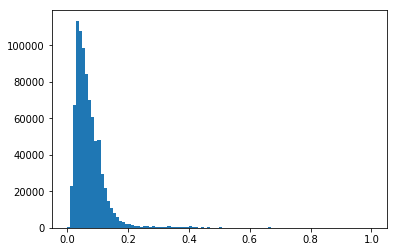

In [108]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.hist(vafs, bins=100)
plt.show()

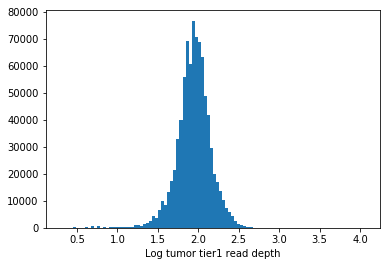

In [162]:
plt.hist(np.log(tumor_tier1_read_depths)/np.log(10), bins=100)
plt.xlabel("Log tumor tier1 read depth")
plt.show()


In [ ]:
write_to_file = True #writing out files will take time

#Disclaimer: I do not know what a good VAF threshold is. I note
#that most of the stuff that comes up when I set a threshold of 1.0
#is from chrY, which seeems like an artifact.
vaf_thresholds = [0.2, 0.4, 0.6, 0.8, 0.9, 1.0]#[0.0, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 1.0

min_read_depth = 12
max_read_depth = 1000

for vaf_threshold in vaf_thresholds:
    if (write_to_file):
        vcf_writer = vcf.Writer(open("data/somatic/results/variants/VAF_"+str(vaf_threshold)+"_somatic.snvs.vcf",'w'),
                         vcf_reader)
    total_num = 0
    num_ct_ga = 0
    total_tumor_tier1_reads = 0
    total_tumor_reads = 0
    for vaf,record in zip(vafs,records):
        if (vaf >= vaf_threshold):         
            #DP and FDP are described here: https://sites.google.com/site/strelkasomaticvariantcaller/home/somatic-variant-output
            #DP is read depth, FDP is filtered read depth
            tier1_reads = record.genotype('TUMOR').data.DP - record.genotype('TUMOR').data.FDP 
            #total_tumor_reads += record.genotype('TUMOR').data.DP 
            if (tier1_reads >= min_read_depth and tier1_reads <= max_read_depth):
                total_num += 1
                total_tumor_tier1_reads += tier1_reads
                if ((record.REF[0]=='C' and record.ALT[0]=='A') or (record.REF[0]=='G' and record.ALT[0]=='T')):
                    num_ct_ga += 1
                if (write_to_file):
                    vcf_writer.write_record(record)
    print("\nthreshold",vaf_threshold,"num",total_num)
    if (total_num > 0):
        print("% c->t & g->a:",100*num_ct_ga/total_num)
        print("Mean tier1 read depth:",total_tumor_tier1_reads/total_num)
    if (write_to_file):
        vcf_writer.close()


threshold 0.2 num 16988
% c->t & g->a: 12.1556392748
Mean tier1 read depth: 81.2709559689

threshold